In [1]:
!pip install -r ../pycjs/requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import sys

cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(cur_dir)  # *注意改为项目自定义包的根路径
# print(pkg_rootdir)
if pkg_rootdir not in sys.path:  # 解决ipynb引用上层路径中的模块时的ModuleNotFoundError问题
    sys.path.append(pkg_rootdir)
    print('-- Add root directory "{}" to system path.'.format(pkg_rootdir))

-- Add root directory "/python_kernel/notebook" to system path.


In [3]:
import copy
import pandas as pd

from node_vm2 import NodeVM

from pycjs.open_digger import vm_option_open_digger, get_export_module_open_digger
from pycjs.vm_context_manager import VMContext
from pycjs.metrics import MultiMime

/usr/local/lib/python3.8/dist-packages/node_vm2/__init__.py:17: FutureWarning: node_vm2 is deprecated. Please use deno_vm instead.
  warnings.warn("node_vm2 is deprecated. Please use deno_vm instead.", FutureWarning)


In [4]:
from IPython.display import display

def displaymime(obj, to_format="to_markdown", mime_type="text/plain"):
    try:
        data = getattr(obj, to_format)()
    except AttributeError as e:
        data = str(obj)
        print(e)
    display({
        mime_type: data,
    }, raw=True)
    
valid_text_plain = ['to_csv', 'to_html', 'to_json', 'to_latex', 'to_markdown', 'to_numpy', 'to_string', 'to_xml']
print(f"valid_text_plain for dispalydf: {valid_text_plain}")

valid_text_plain for dispalydf: ['to_csv', 'to_html', 'to_json', 'to_latex', 'to_markdown', 'to_numpy', 'to_string', 'to_xml']


In [5]:
LEN_YEARS = 5
TOP_N_REPOS = 10

year = 2024
startYear = year - LEN_YEARS + 1
endYear = year
startMonth = 1
endMonth = 12
years = [i + startYear for i in range(LEN_YEARS)]

baseOptions = {
   "startYear": startYear,
   "endYear": endYear,
   "startMonth": startMonth,
   "endMonth": endMonth,
   "groupTimeRange": 'year',
   "order": 'DESC'
}

localOptions = {
   "limit": TOP_N_REPOS
}

options = copy.deepcopy(baseOptions)
options.update(localOptions)

In [6]:
vmc = VMContext(**vm_option_open_digger)

In [7]:
vmc.open()

In [8]:
vm = vmc.vm
export_module = get_export_module_open_digger(vm)
openDigger = export_module.openDigger

In [9]:
use_simple_name = True
def row_openrank_postprocess(row):
    # years = [2019, 2020, 2021, 2022, 2023]
    return {
        "x": years,
        "y": row["openrank"],
        "name": row["name"]
    }

def row_activity_postprocess(row):
    # years = [2019, 2020, 2021, 2022, 2023]
    return {
        "x": years,
        "y": row["activity"],
        "name": row["name"]
    }

# 2024中国开源年度报告

## 一. 总体宏观洞察

### 1.5 编程语言

#### 1.5.1 2024年开发者使用编程语言榜单

In [10]:
data = openDigger.driver.clickhouse.query(f"""
SELECT COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language  
FROM events 
WHERE repo_language != '' AND toYear(created_at) = '{year}' 
GROUP BY repo_language 
ORDER BY user_count DESC 
LIMIT 20;
""", {"format": "JSONEachRow"})
displaymime(pd.DataFrame(data))

|    |   user_count |   repo_count | repo_language    |
|---:|-------------:|-------------:|:-----------------|
|  0 |       591223 |       654037 | JavaScript       |
|  1 |       540751 |       499644 | Python           |
|  2 |       439954 |       462496 | TypeScript       |
|  3 |       424901 |       401084 | HTML             |
|  4 |       281403 |       328123 | Java             |
|  5 |       143135 |       106444 | C++              |
|  6 |       137566 |       114166 | CSS              |
|  7 |       131549 |       163796 | C#               |
|  8 |       125521 |       121209 | Go               |
|  9 |       119874 |        79415 | Jupyter Notebook |
| 10 |       100984 |       108019 | PHP              |
| 11 |        93726 |        76276 | Shell            |
| 12 |        84253 |        60389 | C                |
| 13 |        68199 |        62969 | Rust             |
| 14 |        53503 |        48013 | Kotlin           |
| 15 |        48246 |        61620 | Ruby       

#### 1.5.2 2020-2024年开发者使用编程语言趋势

In [11]:
def repo_language_usecount_postprocess(row):
    return {
        "x": row["year"],
        "y": row["user_count"],
        "name": row["repo_language"][0]
    }

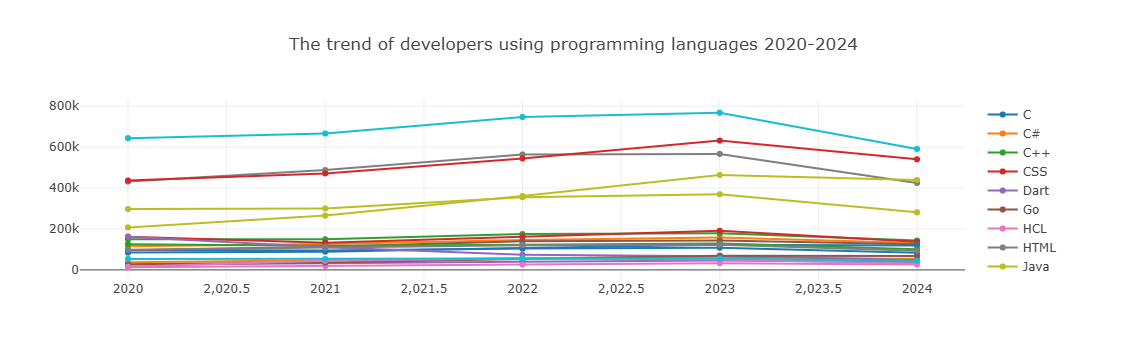

In [12]:
data = openDigger.driver.clickhouse.query(f"""
SELECT toYear(created_at) AS year, COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language
FROM events
WHERE toYear(created_at) IN ('{"', '".join(map(str, years))}') AND repo_language IN (
    SELECT repo_language FROM (
        SELECT COUNT(DISTINCT actor_id) AS user_count, COUNT(DISTINCT repo_id) AS repo_count, repo_language
        FROM events
        WHERE repo_language != '' AND toYear(created_at) = '{year}'
        GROUP BY repo_language
        ORDER BY user_count DESC
        LIMIT 20
    )
)
GROUP BY year, repo_language
ORDER BY year DESC, user_count DESC
""", {"format": "JSONEachRow"})
df_data = pd.DataFrame(data)
data_lang_dict_list = {k: v.to_dict("list") for k, v in df_data.groupby("repo_language")}
data_records = list(map(repo_language_usecount_postprocess, data_lang_dict_list.values()))
openDigger.render.plotly(
    data_records,
    {"title": f"The trend of developers using programming languages {startYear}-{year}", "xasix": {"type": "category"}},
    MultiMime()
)

## 5.技术领域项目分析

技术领域的发展在开源技术中起着风向标的作用，众多技术子领域展现出快速的进步和变革：操作系统领域不断适配新架构，在开源社区中持续演化；云原生技术推动企业实现数字化转型，其开源项目生态活跃且增长迅速；数据库作为数据创新的核心基础设施，开源技术的广泛应用促进了多样化场景的突破；大数据领域依托开源工具，正为智能决策提供强大支撑；人工智能借助开源框架加速各行业的自动化进程；前端技术则通过开源项目推动交互体验与视觉设计的不断提升。这些领域以其开放性和创新性吸引了众多开发者与投资者的关注，本节将基于影响力和活跃度两大指标对其进行数据洞察分析。

### 5.1 各领域OpenRank Top 10 榜单

### 大数据

In [13]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/big_data'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                  | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:----------------------|:-----------|
|  0 |   7833168 | GitHub     |       1 |      1 |            1 | elastic/kibana        | [7380.26]  |
|  1 |  15111821 | GitHub     |       1 |      1 |            1 | grafana/grafana       | [6335.71]  |
|  2 |  60246359 | GitHub     |       1 |      1 |            1 | ClickHouse/ClickHouse | [4726.33]  |
|  3 |  99919302 | GitHub     |       1 |      1 |            1 | apache/doris          | [3965.48]  |
|  4 |    507775 | GitHub     |       1 |      1 |            1 | elastic/elasticsearch | [3912.42]  |
|  5 | 283046497 | GitHub     |       1 |      1 |            1 | airbytehq/airbyte     | [3299.4]   |
|  6 | 402945349 | GitHub     |       1 |      1 |            1 | StarRocks/starrocks   | [3034.08]  |
|  7 |  33884891 | GitHub     |       1 |      1 |            1 | apache/

### 数据库

In [14]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/database'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                  | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:----------------------|:-----------|
|  0 |  60246359 | GitHub     |       1 |      1 |            1 | ClickHouse/ClickHouse | [4726.33]  |
|  1 |  99919302 | GitHub     |       1 |      1 |            1 | apache/doris          | [3965.48]  |
|  2 |    507775 | GitHub     |       1 |      1 |            1 | elastic/elasticsearch | [3912.42]  |
|  3 | 402945349 | GitHub     |       1 |      1 |            1 | StarRocks/starrocks   | [3034.08]  |
|  4 |  16563587 | GitHub     |       1 |      1 |            1 | cockroachdb/cockroach | [2506.6]   |
|  5 |  17165658 | GitHub     |       1 |      1 |            1 | apache/spark          | [2485.28]  |
|  6 | 456549280 | GitHub     |       1 |      1 |            1 | ydb-platform/ydb      | [2216.9]   |
|  7 | 166515022 | GitHub     |       1 |      1 |            1 | trinodb

### 操作系统

In [15]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/operating_system'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                         | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:-----------------------------|:-----------|
|  0 | 160083795 | GitHub     |       1 |      1 |            1 | SerenityOS/serenity          | [1020.8]   |
|  1 | 105627846 | GitHub     |       1 |      1 |            1 | reactos/reactos              | [757.97]   |
|  2 |  24905898 | GitHub     |       1 |      1 |            1 | armbian/build                | [551.48]   |
|  3 | 179385712 | GitHub     |       1 |      1 |            1 | bottlerocket-os/bottlerocket | [290.52]   |
|  4 |  36428094 | GitHub     |       1 |      1 |            1 | tock/tock                    | [259.8]    |
|  5 |   2325298 | GitHub     |       1 |      1 |            1 | torvalds/linux               | [230.9]    |
|  6 | 181022316 | GitHub     |       1 |      1 |            1 | unikraft/unikraft            | [229.1]    |
|  7 |  61

### 云原生

In [16]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/cloud_native'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                   | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:-----------------------|:-----------|
|  0 |  75821432 | GitHub     |       1 |      1 |            1 | llvm/llvm-project      | [20074.69] |
|  1 |  15111821 | GitHub     |       1 |      1 |            1 | grafana/grafana        | [6335.71]  |
|  2 |  60246359 | GitHub     |       1 |      1 |            1 | ClickHouse/ClickHouse  | [4726.33]  |
|  3 |  20580498 | GitHub     |       1 |      1 |            1 | kubernetes/kubernetes  | [3924.93]  |
|  4 |   2310495 | GitHub     |       1 |      1 |            1 | ceph/ceph              | [3173.94]  |
|  5 |  48109239 | GitHub     |       1 |      1 |            1 | cilium/cilium          | [2842.98]  |
|  6 |  11125589 | GitHub     |       1 |      1 |            1 | keycloak/keycloak      | [2687.79]  |
|  7 |  31558937 | GitHub     |       1 |      1 |            1 

### 前端

In [17]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/frontend'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                  | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:----------------------|:-----------|
|  0 |  31792824 | GitHub     |       1 |      1 |            1 | flutter/flutter       | [6531.03]  |
|  1 |  70107786 | GitHub     |       1 |      1 |            1 | vercel/next.js        | [4450.37]  |
|  2 | 275993885 | GitHub     |       1 |      1 |            1 | appsmithorg/appsmith  | [2402.2]   |
|  3 |  29028775 | GitHub     |       1 |      1 |            1 | facebook/react-native | [2302.11]  |
|  4 |  24195339 | GitHub     |       1 |      1 |            1 | angular/angular       | [2269.04]  |
|  5 |  34526884 | GitHub     |       1 |      1 |            1 | ant-design/ant-design | [1962.73]  |
|  6 |  27193779 | GitHub     |       1 |      1 |            1 | nodejs/node           | [1925.41]  |
|  7 |  74293321 | GitHub     |       1 |      1 |            1 | sveltej

### 人工智能

In [18]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                     | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:-------------------------|:-----------|
|  0 |  65600975 | GitHub     |       1 |      1 |            1 | pytorch/pytorch          | [11303.04] |
|  1 | 599547518 | GitHub     |       1 |      1 |            1 | vllm-project/vllm        | [4611]     |
|  2 | 155220641 | GitHub     |       1 |      1 |            1 | huggingface/transformers | [4292.13]  |
|  3 | 552661142 | GitHub     |       1 |      1 |            1 | langchain-ai/langchain   | [4212.26]  |
|  4 |  65711522 | GitHub     |       1 |      1 |            1 | PaddlePaddle/Paddle      | [4001.71]  |
|  5 | 153097643 | GitHub     |       1 |      1 |            1 | openvinotoolkit/openvino | [3538.16]  |
|  6 | 612354784 | GitHub     |       1 |      1 |            1 | ggerganov/llama.cpp      | [3110.07]  |
|  7 | 156939672 | GitHub     |       1 |     

### 3.2 各领域 OpenRank Top 10项目近五年变化趋势

In [19]:
def processTechFieldRepoOpenrank(label, title):
    data = openDigger.index.openrank.getRepoOpenrank(
        dict(**baseOptions, 
             **{"labelIntersect": [label], "limit": 10}
            )
    )
    data_records = pd.DataFrame(data).apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        {"title": f"Top 10 OpenRank repositories of {title} {startYear}-{year}"},
        MultiMime()
    )

In [20]:
def processTechFieldRepoActivity(label, title):
    data = openDigger.index.activity.getRepoActivity(
        dict(**baseOptions, 
             **{"labelIntersect": [label], "limit": 10}
            )
    )
    data_records = pd.DataFrame(data).apply(row_activity_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records, 
        {"title": f"Top 10 Activity repositories of {title} {startYear}-{year}"},
        MultiMime()
    )

### 大数据

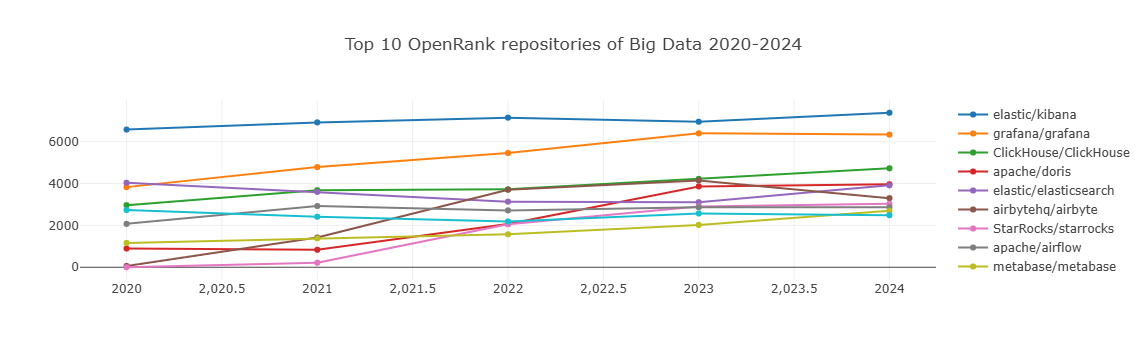

In [21]:
processTechFieldRepoOpenrank(':technology/big_data', 'Big Data');

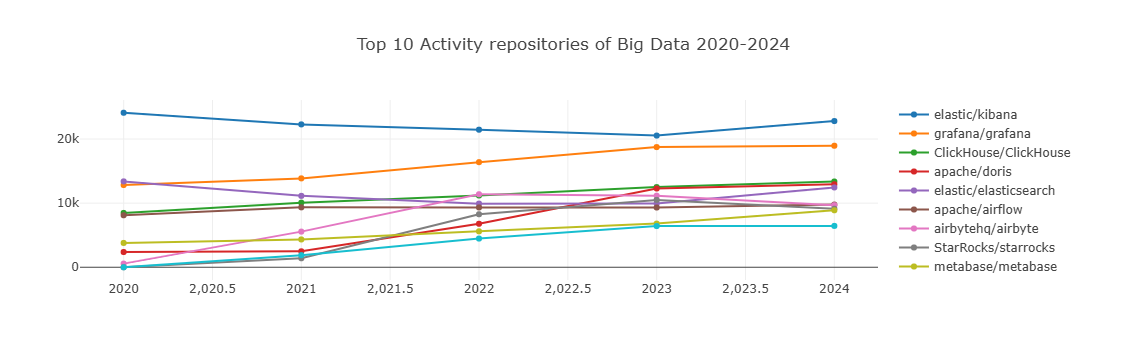

In [22]:
processTechFieldRepoActivity(':technology/big_data', 'Big Data')

### 数据库

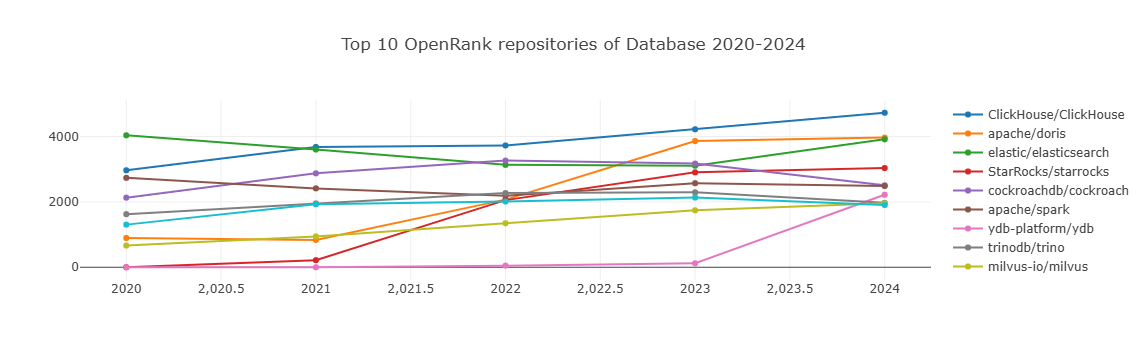

In [23]:
processTechFieldRepoOpenrank(':technology/database', 'Database');

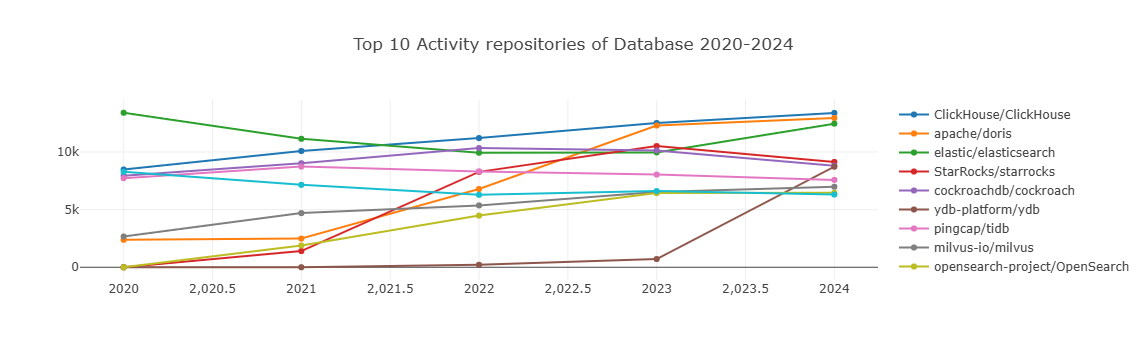

In [24]:
processTechFieldRepoActivity(':technology/database', 'Database');

### 操作系统

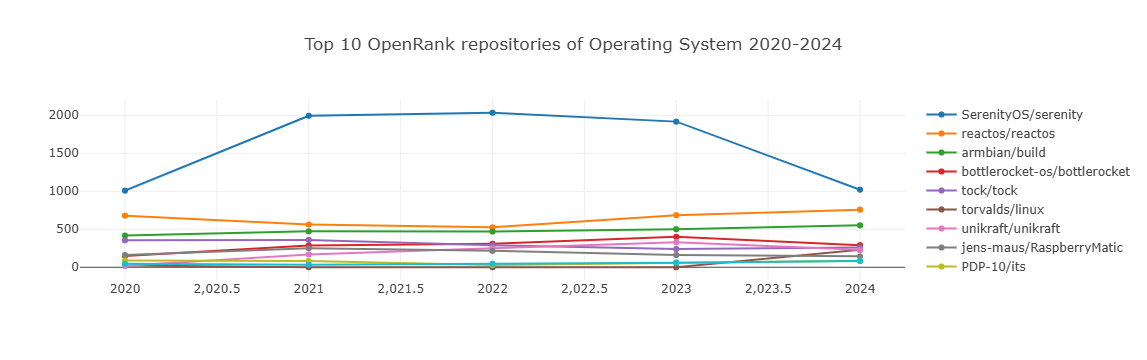

In [25]:
processTechFieldRepoOpenrank(':technology/operating_system', 'Operating System');

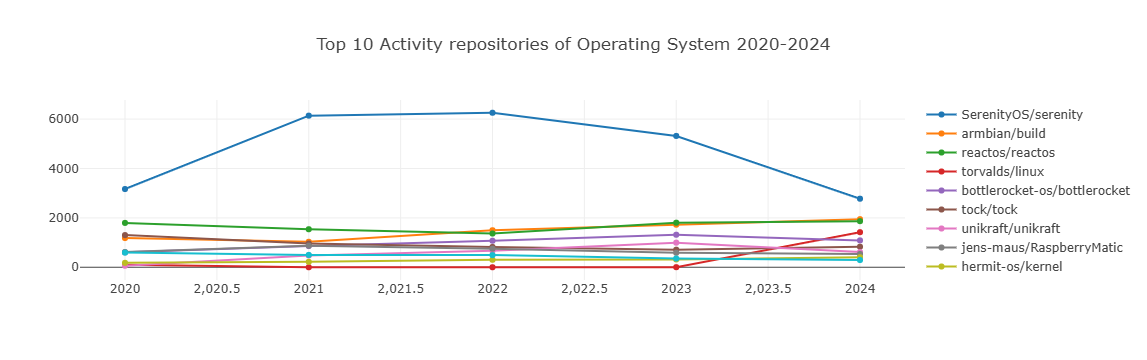

In [26]:
processTechFieldRepoActivity(':technology/operating_system', 'Operating System');

### 云原生

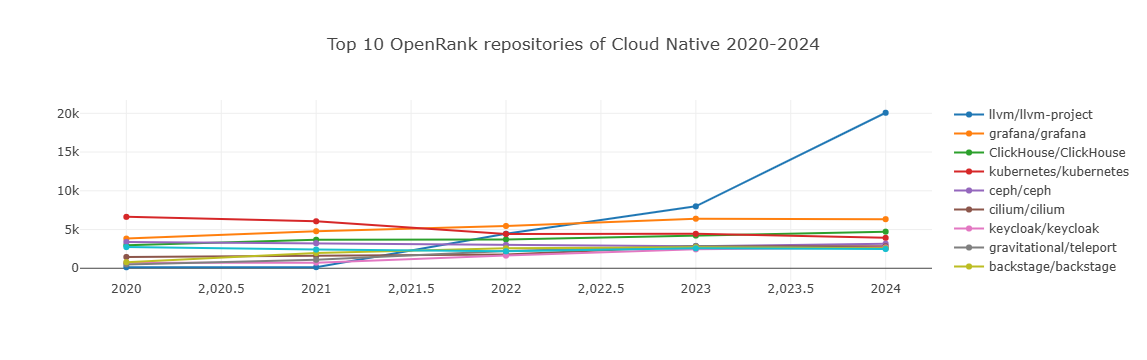

In [27]:
processTechFieldRepoOpenrank(':technology/cloud_native', 'Cloud Native');

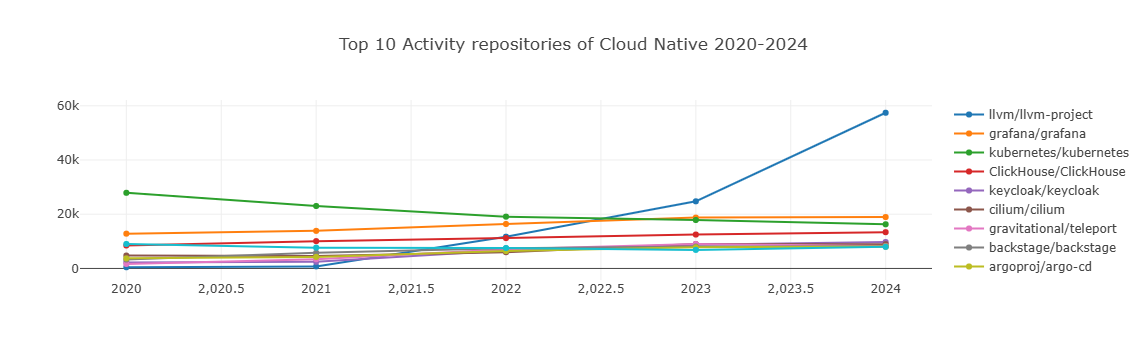

In [28]:
processTechFieldRepoActivity(':technology/cloud_native', 'Cloud Native');

### 前端

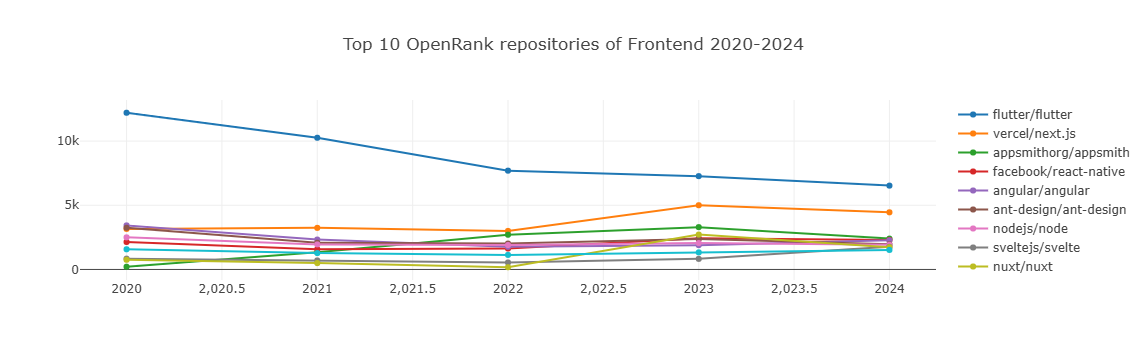

In [29]:
processTechFieldRepoOpenrank(':technology/frontend', 'Frontend');

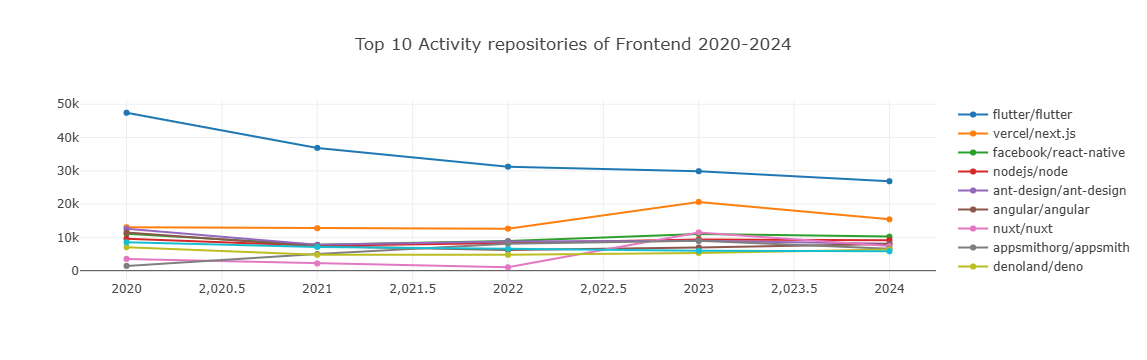

In [30]:
processTechFieldRepoActivity(':technology/frontend', 'Frontend');

### 人工智能

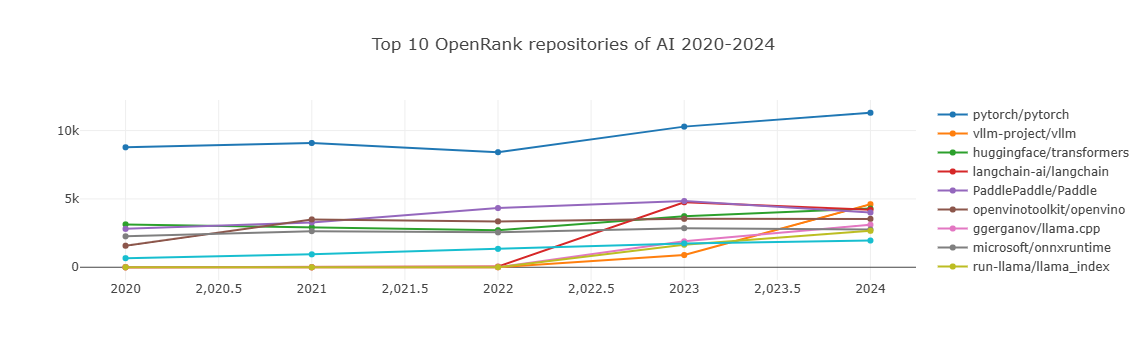

In [31]:
processTechFieldRepoOpenrank(':technology/ai', 'AI');

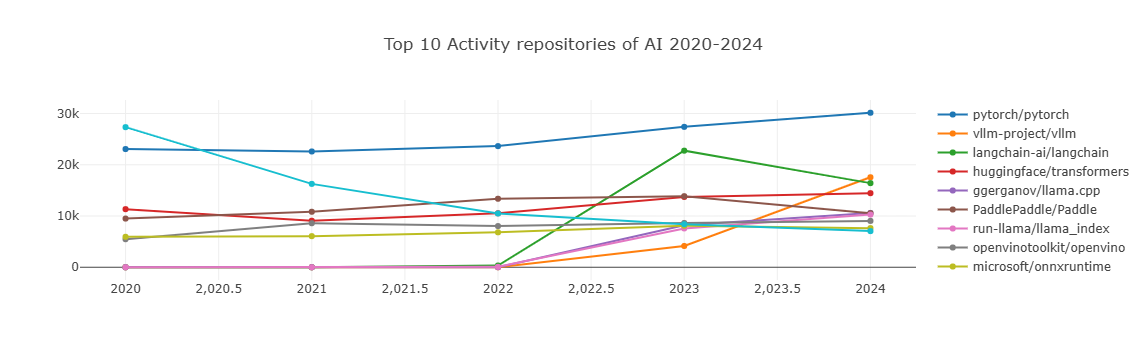

In [32]:
processTechFieldRepoActivity(':technology/ai', 'AI');

### 3.3 各子领域近5年变化趋势

In [33]:
def processTechSubfieldsRepoOpenrank(options, title_meta, use_simple_name=True):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

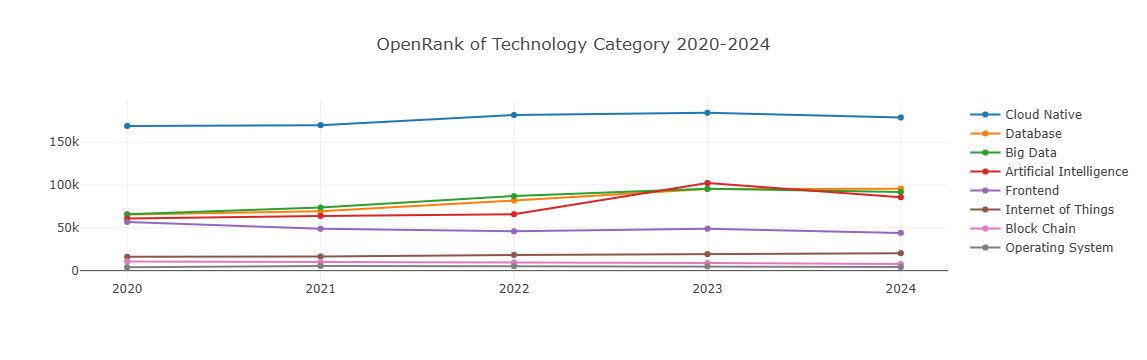

In [34]:
processTechSubfieldsRepoOpenrank({
    "labelUnion": ['Tech-0'],  # ':technology' is invalid because there is no such a top level label for the technology directory. 'Tech-0' can be used to represent the first level technical field label
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": f"OpenRank of Technology Category {startYear}-{year}", "xaxis": { "type": 'category' }})

In [35]:
def processTechSubfieldsRepoActivity(options, title_meta, use_simple_name=True):
    data = openDigger.index.activity.getRepoActivity(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

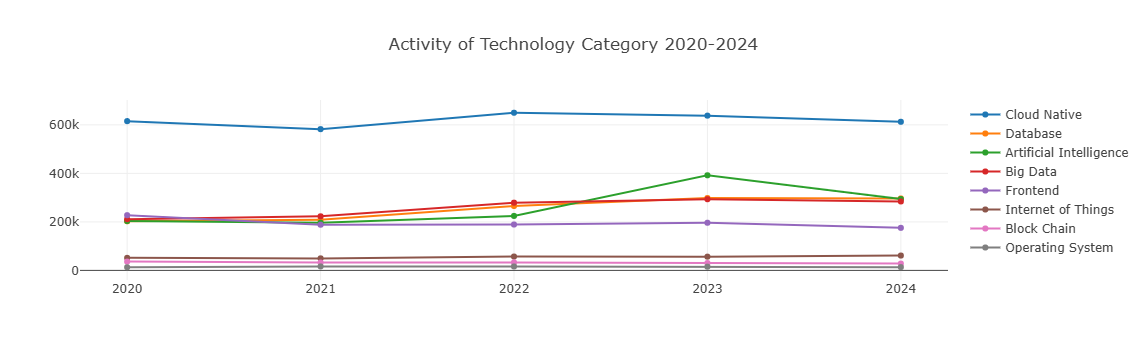

In [36]:
processTechSubfieldsRepoActivity({
    "labelUnion": ['Tech-0'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": f"Activity of Technology Category {startYear}-{year}", "xaxis": { "type": 'category' }})

## 6.开源项目洞察

### 6.1 不同项目类型数量比例

![jupyter](./img/repo_count.png)

### 6.2 不同项目类型 OpenRank 加总比例

In [37]:
def df_openrank_postprocess(df):
    return [{
        "labels": df["name"].values.tolist(),
        "values": df["openrank"].apply(lambda x: x[0]).values.tolist(),
        "type": 'pie',
        "name": 'times',
        "textinfo": "label+percent"
    }]

def processApplyRatioRepoOpenrank(options, title_meta):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = df_openrank_postprocess(data_df_formated)
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

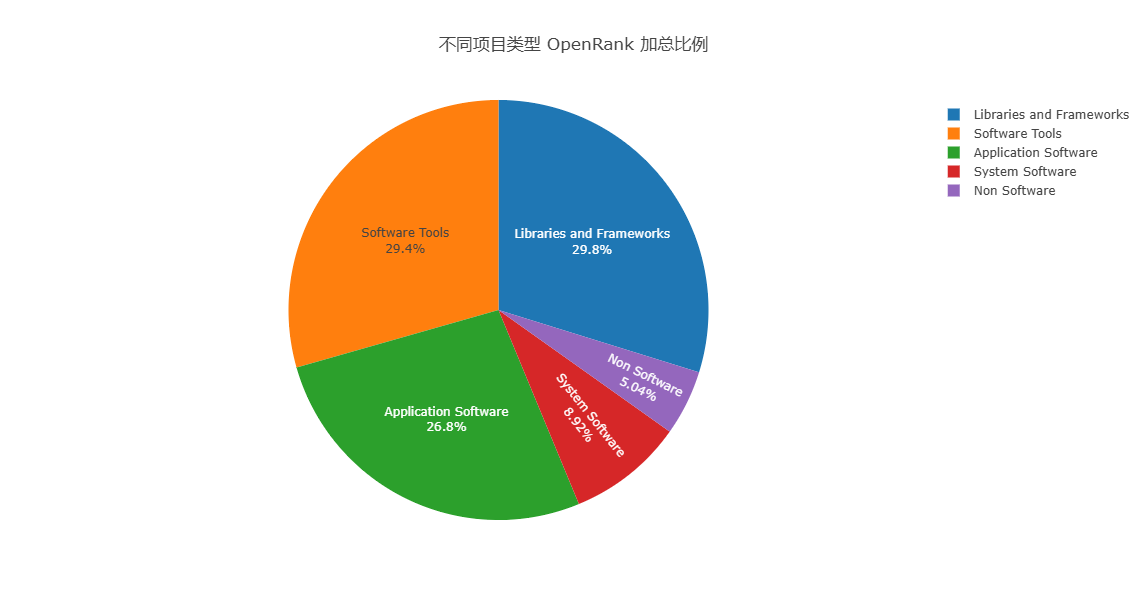

In [38]:
processApplyRatioRepoOpenrank({
    "labelUnion": [':application_domain'],
    "startYear": year, "endYear": year, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {
    "title": '不同项目类型 OpenRank 加总比例',
    "xaxis": {"type": 'category'},
    "height": 600,
    # "width":1050,
})

### 6.3 不同项目类型 近5年 OpenRank 变化趋势

In [39]:
def processApplySubfieldsRepoOpenrank(options, title_meta, use_simple_name=True):
    data = openDigger.index.openrank.getRepoOpenrank(options)
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':application_domain'), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_records,
        title_meta,
        MultiMime()
    )

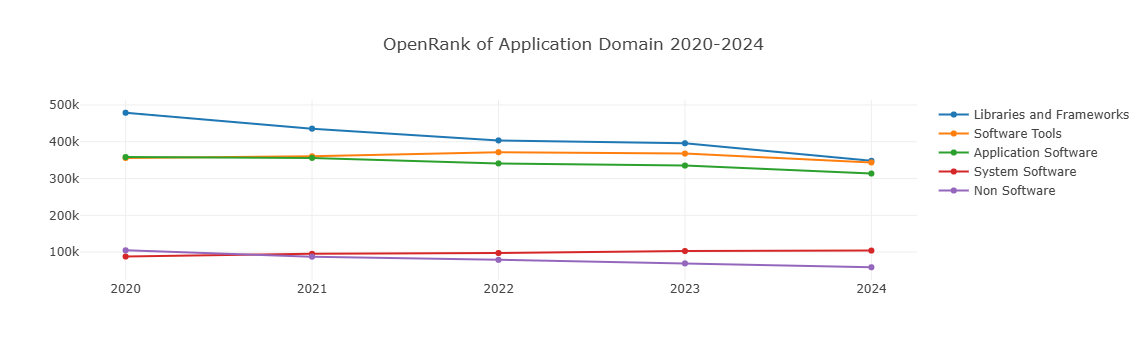

In [40]:
processApplySubfieldsRepoOpenrank({
    "labelUnion": [':application_domain'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Domain-0',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
}, {"title": f"OpenRank of Application Domain {startYear}-{year}", "xaxis": { "type": 'category' }})

### 6.4 数据库领域项目分析

### 数据库领域项目 OpenRank Top 10

数据库领域 2024 年度 OpenRank 指标 Top 10 的项目排行榜

In [41]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], "startYear": year, "endYear": year, "limit": 10}
))
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                  | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:----------------------|:-----------|
|  0 |  60246359 | GitHub     |       1 |      1 |            1 | ClickHouse/ClickHouse | [4726.33]  |
|  1 |  99919302 | GitHub     |       1 |      1 |            1 | apache/doris          | [3965.48]  |
|  2 |    507775 | GitHub     |       1 |      1 |            1 | elastic/elasticsearch | [3912.42]  |
|  3 | 402945349 | GitHub     |       1 |      1 |            1 | StarRocks/starrocks   | [3034.08]  |
|  4 |  16563587 | GitHub     |       1 |      1 |            1 | cockroachdb/cockroach | [2506.6]   |
|  5 |  17165658 | GitHub     |       1 |      1 |            1 | apache/spark          | [2485.28]  |
|  6 | 456549280 | GitHub     |       1 |      1 |            1 | ydb-platform/ydb      | [2216.9]   |
|  7 | 166515022 | GitHub     |       1 |      1 |            1 | trinodb

### 数据库领域项目 活跃度 Top 10

数据库领域 2024 年度 Activity 指标 Top 10 的项目排行榜

In [42]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], "startYear": year, "endYear": year, "limit": 10}
))
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                          | activity   | participants   | issue_comment   | open_issue   | open_pull   | review_comment   | merged_pull   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:------------------------------|:-----------|:---------------|:----------------|:-------------|:------------|:-----------------|:--------------|
|  0 |  60246359 | GitHub     |       1 |      1 |            1 | ClickHouse/ClickHouse         | [13379.14] | ['4917']       | ['30836']       | ['3685']     | ['10495']   | ['10383']        | ['8862']      |
|  1 |  99919302 | GitHub     |       1 |      1 |            1 | apache/doris                  | [12945.22] | ['2486']       | ['138339']      | ['1166']     | ['14339']   | ['14823']        | ['12510']     |
|  2 |    507775 | GitHub     |       1 |      1 |            1 | elastic/elasticsearch         | [12452.42] | ['3073']       | ['38913']       | ['3391']     |

### 数据库领域 近5年 OpenRank和Activity 变化趋势

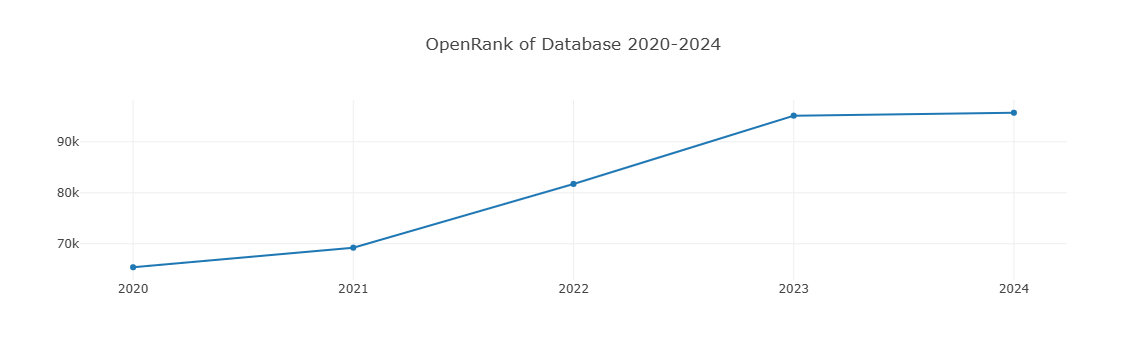

In [43]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_records = data_df_filtered.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of Database {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

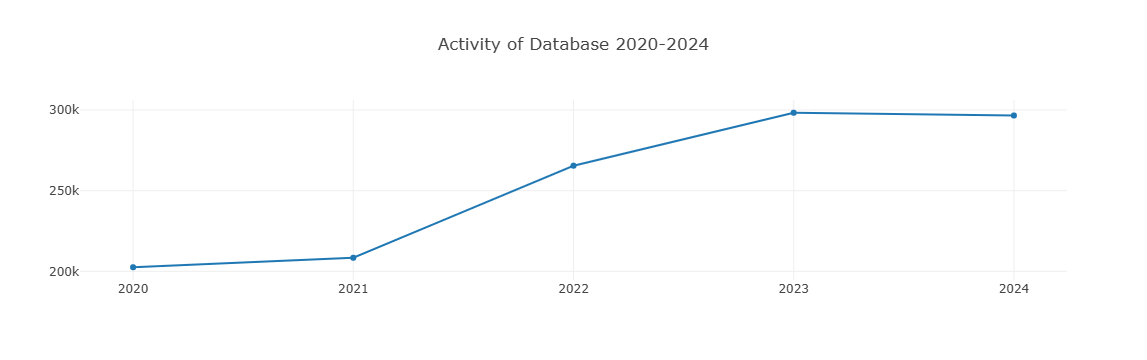

In [44]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": ['Tech-0'],
    "groupBy": 'Tech-0',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_records = data_df_filtered.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of Database {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 数据库领域各子领域 2024年 OpenRank 榜单

In [45]:
use_simple_name = True

In [46]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year, 
    "groupBy": 'Tech-1', 
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
displaymime(data_df_formated)

|    | id                                   | platform   | repos   | orgs    | developers   | name            | openrank   |
|---:|:-------------------------------------|:-----------|:--------|:--------|:-------------|:----------------|:-----------|
|  0 | :technology/database/relational      | All        | ['127'] | ['100'] | ['1']        | Relational      | [55440.51] |
|  3 | :technology/database/key_value       | All        | ['105'] | ['73']  | ['1']        | Key-value       | [18780.06] |
|  4 | :technology/database/document        | All        | ['96']  | ['65']  | ['1']        | Document        | [18262.05] |
|  5 | :technology/database/wide_column     | All        | ['16']  | ['12']  | ['1']        | Wide Column     | [11285.39] |
|  6 | :technology/database/search_engine   | All        | ['9']   | ['9']   | ['1']        | Search Engine   | [7575.18]  |
|  7 | :technology/database/time_series     | All        | ['25']  | ['25']  | ['1']        | Time Series     | [7111.37]  |


### 数据库领域各子领域 2024年 Activity 榜单

In [47]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year, 
    "groupBy": 'Tech-1', 
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
displaymime(data_df_formated)

|    | id                                   | platform   | repos   | orgs    | developers   | name            | activity    | participants   | issue_comment   | open_issue   | open_pull   | review_comment   | merged_pull   |
|---:|:-------------------------------------|:-----------|:--------|:--------|:-------------|:----------------|:------------|:---------------|:----------------|:-------------|:------------|:-----------------|:--------------|
|  0 | :technology/database/relational      | All        | ['127'] | ['100'] | ['17702']    | Relational      | [166706.88] | ['47294']      | ['715404']      | ['45356']    | ['132127']  | ['223408']       | ['104765']    |
|  3 | :technology/database/key_value       | All        | ['108'] | ['75']  | ['7528']     | Key-value       | [58567.07]  | ['18672']      | ['243668']      | ['15589']    | ['31733']   | ['88522']        | ['22559']     |
|  4 | :technology/database/document        | All        | ['99']  | ['66']  | ['6804']     | Docume

### 数据库领域各子领域 近5年 OpenRank 变化趋势

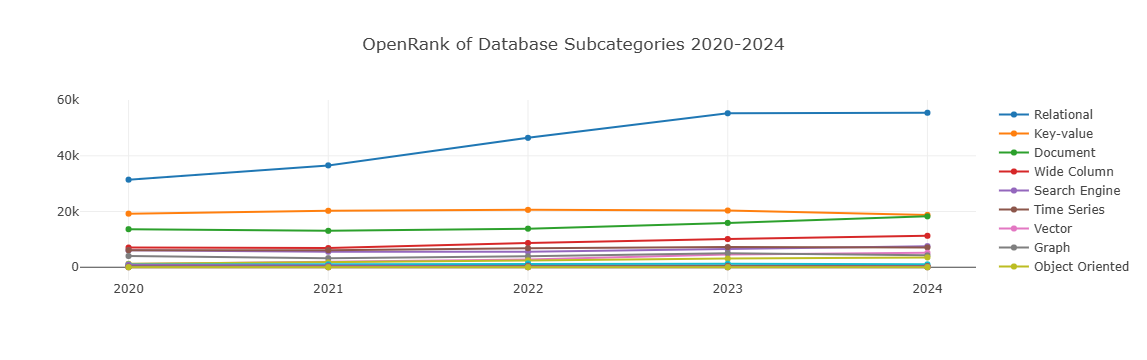

In [48]:
data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of Database Subcategories {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [49]:
def openrank_rank_postporcess(row):
    return {
        "x": years,
        "y": row["values"],
        "name": row["name"],
        "type": 'scatter'
    }
def processSubfieldRankRepoOpenrank(options, title):
    data = openDigger.index.openrank.getRepoOpenrank(dict(
        baseOptions, 
        **options
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["name"].startswith('Database - '), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = pd.DataFrame(data_df_formated).to_dict('records')
    data_periodranks = openDigger.getRank(data_records, lambda x: x["name"], lambda x: x["openrank"])
    data_periodranks_records = pd.DataFrame(data_periodranks).apply(openrank_rank_postporcess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_periodranks_records, 
        {
            "title": f"OpenRank of {title} Subcategories Ranking {startYear}-{year}", 
            "xaxis": { "type": 'category' }, 
            "yaxis": { "autorange": 'reversed', "dtick": 1 } 
        }, 
        MultiMime()
    )

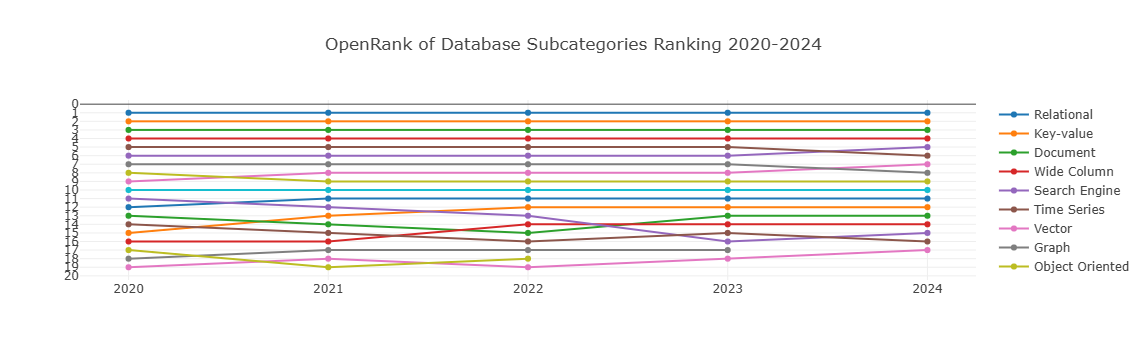

In [50]:
processSubfieldRankRepoOpenrank({
    "labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1}, "Database")

### 数据库领域各子领域 近5年 Activity 变化趋势

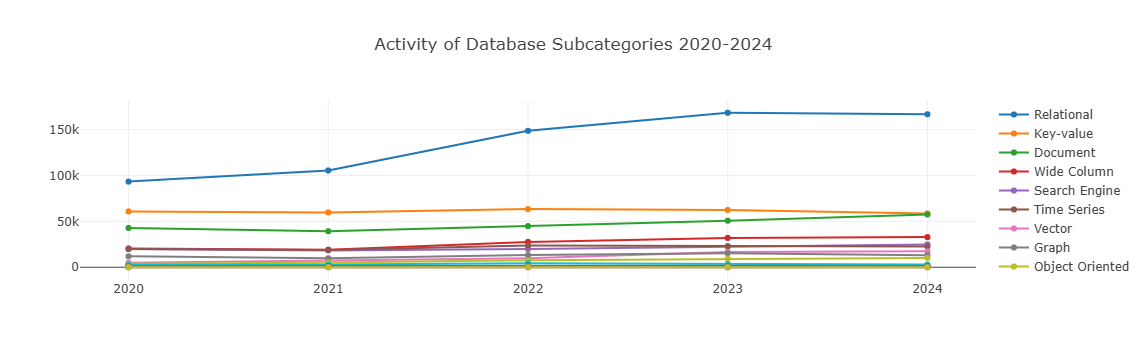

In [51]:
data = openDigger.index.activity.getRepoActivity(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1
    }
))
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/database'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of Database Subcategories {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

In [52]:
def activity_rank_postporcess(row):
    return {
        "x": years,
        "y": row["values"],
        "name": row["name"],
        "type": 'scatter'
    }
def processSubfieldRankRepoActivity(options, title):
    data = openDigger.index.activity.getRepoActivity(dict(
        baseOptions, 
        **options
    ))
    data_df = pd.DataFrame(data)
    data_df_filtered = data_df[data_df.apply(lambda row: row["name"].startswith('Database - '), axis=1)]
    data_df_formated = data_df_filtered.copy()
    if use_simple_name:
        data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
    data_records = pd.DataFrame(data_df_formated).to_dict('records')
    data_periodranks = openDigger.getRank(data_records, lambda x: x["name"], lambda x: x["activity"])
    data_periodranks_records = pd.DataFrame(data_periodranks).apply(activity_rank_postporcess, axis=1).values.tolist()
    openDigger.render.plotly(
        data_periodranks_records, 
        {
            "title": f"Activity of {title} Subcategories Ranking {startYear}-{year}", 
            "xaxis": { "type": 'category' }, 
            "yaxis": { "autorange": 'reversed', "dtick": 1 } 
        }, 
        MultiMime()
    )

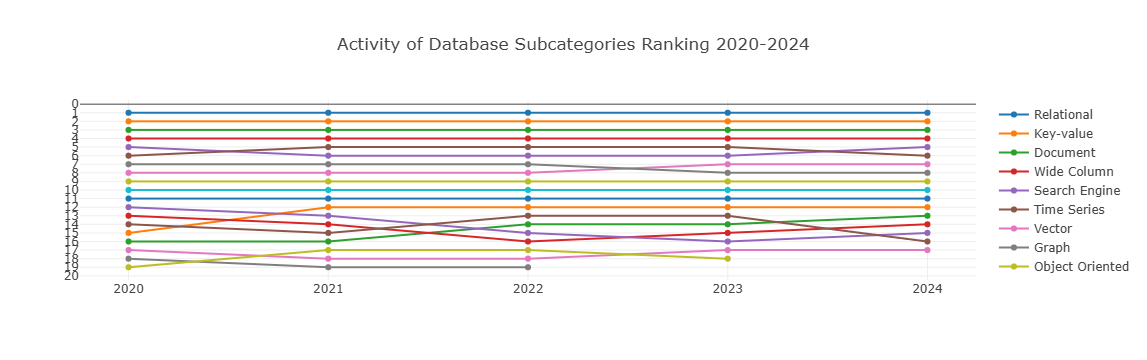

In [53]:
processSubfieldRankRepoActivity({
    "labelUnion": [':technology/database'],
    "groupBy": 'Tech-1',
    "limit": -1}, "Database")

### 开源数据库 OpenRank Top30 项目时区打点分布图

此处将根据开源数据库项目 OpenRank Top 30 在 2024 全年中的事件按事件分布情况绘制打孔图，从而可以观察项目的工作时间分布情况。

In [54]:
import json
import math

data = openDigger.index.openrank.getRepoOpenrank(dict(
    baseOptions, 
    **{"labelUnion": [':technology/database'], 
    "startYear": year, "endYear": year,
    "limit": 30,
    }
))
data_df = pd.DataFrame(data)
ids = data_df["id"].values.tolist()
sql = f"""
SELECT repo_id, argMax(name, time) AS name, groupArray(count) AS data
FROM
(SELECT repo_id, argMax(repo_name, created_at) AS name, MAX(created_at) AS time, toDayOfWeek(created_at) AS weekday, toHour(created_at) AS hour, COUNT() AS count
FROM events
WHERE toYear(created_at)={year} AND repo_id IN ('{"','".join(ids)}')
GROUP BY repo_id, weekday, hour
ORDER BY weekday, hour)
GROUP BY repo_id
"""
data_time_distribution = openDigger.driver.clickhouse.query(sql)
for d in data_time_distribution:
    maxCount = max(list(map(float,d[2])))
    d_ceiled = [math.ceil(int(c)*10/maxCount) for c in d[2]]
    print(f"项目 {d[1]} 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data={json.dumps(d_ceiled, separators=(',', ':'))}");


项目 apache/pinot 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[1,1,1,1,1,3,3,3,4,3,4,10,4,4,4,3,5,6,9,6,8,6,7,6,7,3,2,3,3,4,4,3,4,4,5,9,3,4,3,3,4,8,10,7,5,7,7,6,5,4,2,2,4,4,4,4,3,3,4,8,2,3,3,3,4,8,7,6,7,8,7,6,5,3,2,2,4,5,4,4,3,3,3,8,3,3,2,2,5,7,8,5,6,6,6,6,4,4,2,2,4,4,3,4,3,3,3,8,3,3,3,2,3,5,7,4,5,6,4,4,4,2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,2,2,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,1]
项目 grafana/mimir 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?data=[4,4,3,4,4,2,8,10,10,9,8,7,5,7,8,7,6,6,5,4,3,3,3,3,2,3,2,3,3,3,4,6,6,7,6,6,6,7,7,7,6,5,4,3,2,3,4,3,2,3,2,2,3,3,3,6,6,7,8,8,6,6,7,8,7,6,5,4,3,3,3,3,2,2,1,3,3,2,3,5,6,7,7,6,5,7,7,8,8,6,5,4,4,3,4,3,4,2,2,2,2,3,3,5,6,7,8,6,7,7,7,7,6,6,3,4,4,4,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2]
项目 apache/shardingsphere 的工作时间分布链接为：https://oss.x-lab.info/open_digger/assets/working_hour_distribution.svg?dat

### 6.5 生成式AI领域项目分析

### 生成式AI领域项目 OpenRank Top 10

此处给出数个生成式AI领域 2024 年度 OpenRank 指标 Top 10 项目及其自 2020 年起的 OpenRank 变化趋势。*

In [55]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                              | openrank   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:----------------------------------|:-----------|
|  0 | 599547518 | GitHub     |       1 |      1 |            1 | vllm-project/vllm                 | [4611]     |
|  1 | 155220641 | GitHub     |       1 |      1 |            1 | huggingface/transformers          | [4292.13]  |
|  2 | 552661142 | GitHub     |       1 |      1 |            1 | langchain-ai/langchain            | [4212.26]  |
|  3 | 612354784 | GitHub     |       1 |      1 |            1 | ggerganov/llama.cpp               | [3110.07]  |
|  4 | 560704231 | GitHub     |       1 |      1 |            1 | run-llama/llama_index             | [2665.89]  |
|  5 | 208728772 | GitHub     |       1 |      1 |            1 | milvus-io/milvus                  | [1955.52]  |
|  6 | 388946490 | GitHub     |       1 |      1 |            1 | facebookincuba

### 生成式AI领域项目 活跃度 Top 10

In [56]:
data = openDigger.index.activity.getRepoActivity({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": year, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "limit": 10, "order": 'DESC',
})
displaymime(pd.DataFrame(data))

|    |        id | platform   |   repos |   orgs |   developers | name                                 | activity   | participants   | issue_comment   | open_issue   | open_pull   | review_comment   | merged_pull   |
|---:|----------:|:-----------|--------:|-------:|-------------:|:-------------------------------------|:-----------|:---------------|:----------------|:-------------|:------------|:-----------------|:--------------|
|  0 | 599547518 | GitHub     |       1 |      1 |            1 | vllm-project/vllm                    | [17556.02] | ['10009']      | ['39521']       | ['4088']     | ['4364']    | ['15559']        | ['3183']      |
|  1 | 552661142 | GitHub     |       1 |      1 |            1 | langchain-ai/langchain               | [16413.39] | ['9412']       | ['24711']       | ['2661']     | ['7091']    | ['6268']         | ['5664']      |
|  2 | 155220641 | GitHub     |       1 |      1 |            1 | huggingface/transformers             | [14454.74] | ['7669']      

### 生成式AI领域 OpenRank Top 10 项目近5年增长趋势

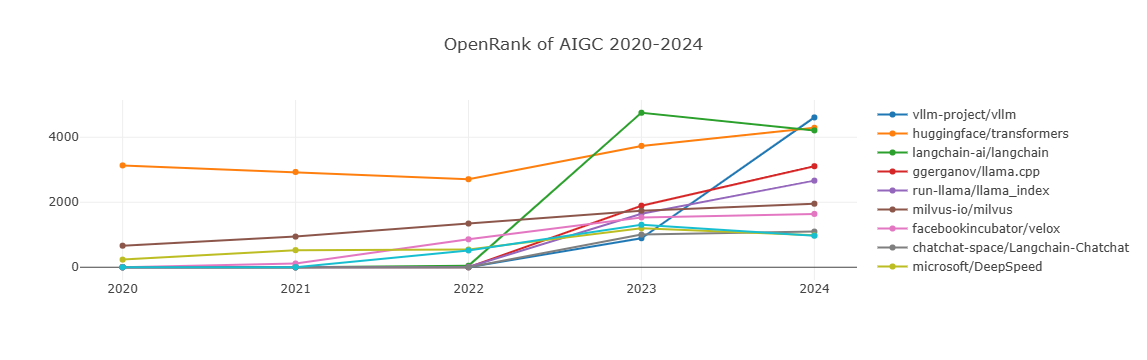

In [57]:
data = openDigger.index.openrank.getRepoOpenrank({
    "startYear": startYear, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "order": 'DESC', "labelIntersect": [':technology/ai/generative_ai'], "limit": 10
})

data_df = pd.DataFrame(data)
data_records = data_df.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of AIGC {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 生成式AI领域 活跃度 Top 10 项目近5年增长趋势

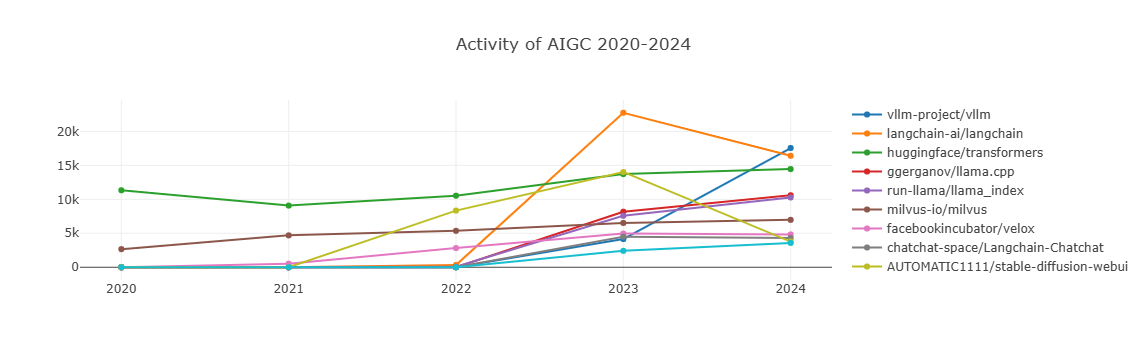

In [58]:
data = openDigger.index.activity.getRepoActivity({
    "startYear": startYear, "endYear": year, "startMonth": 1, "endMonth": 12,
    "groupTimeRange": 'year', "order": 'DESC', "labelIntersect": [':technology/ai/generative_ai'], "limit": 10
})
data_df = pd.DataFrame(data)
data_records = data_df.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of AIGC {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 生成式AI各子领域近5年增长趋势

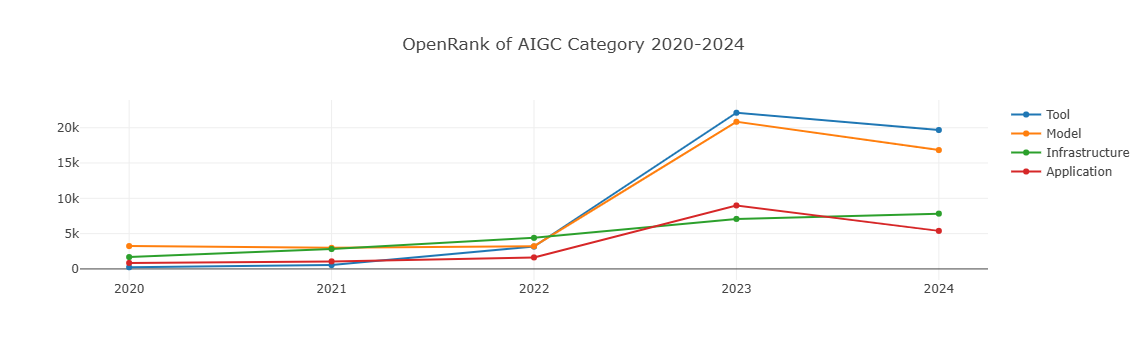

In [59]:
data = openDigger.index.openrank.getRepoOpenrank({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-2',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
})
data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/ai/generative_ai'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_openrank_postprocess, axis=1).values.tolist()
title_meta = {"title": f"OpenRank of AIGC Category {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

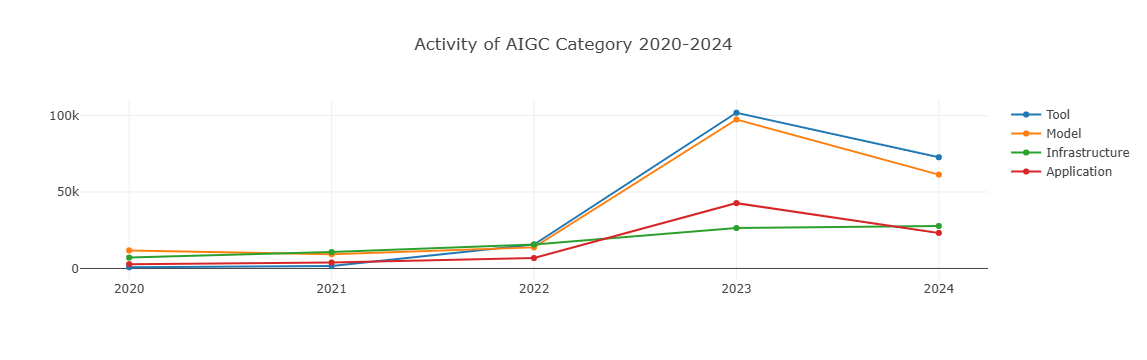

In [60]:
data = openDigger.index.activity.getRepoActivity({
    "labelUnion": [':technology/ai/generative_ai'],
    "startYear": startYear, "endYear": year, "endMonth": 12,
    "groupBy": 'Tech-2',
    "groupTimeRange": 'year',
    "order": 'DESC',
    "limit": -1
})

data_df = pd.DataFrame(data)
data_df_filtered = data_df[data_df.apply(lambda row: row["id"].startswith(':technology/ai/generative_ai'), axis=1)]
data_df_formated = data_df_filtered.copy()
if use_simple_name:
    data_df_formated["name"] = data_df_formated["name"].apply(lambda x: x.split(' - ')[-1])
data_records = data_df_formated.apply(row_activity_postprocess, axis=1).values.tolist()
title_meta = {"title": f"Activity of AIGC Category {startYear}-{year}", "xaxis": { "type": 'category' }}
openDigger.render.plotly(
    data_records,
    title_meta,
    MultiMime()
)

### 6.6 项目 Topic 分析

![jupyter](./img/topic_top10.png)

In [61]:
vmc.close()